# Forecast Evaluations

### Classic Train/Test Split

In [1]:
import pandas as pd
from fbprophet import Prophet
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [2]:
#Prophet deregisters the Pandas converters in its code.
#Please check https://darektidwell.com/typeerror-float-argument-must-be-a-string-or-a-number-not-period-facebook-prophet-and-pandas/
pd.plotting.register_matplotlib_converters()

In [3]:
df = pd.read_csv('Miles_Traveled.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
DATE                588 non-null object
TRFVOLUSM227NFWA    588 non-null float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


In [5]:
df.head()

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [6]:
df.columns = ['ds','y']

In [7]:
df['ds'] = pd.to_datetime(df['ds'])

In [8]:
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


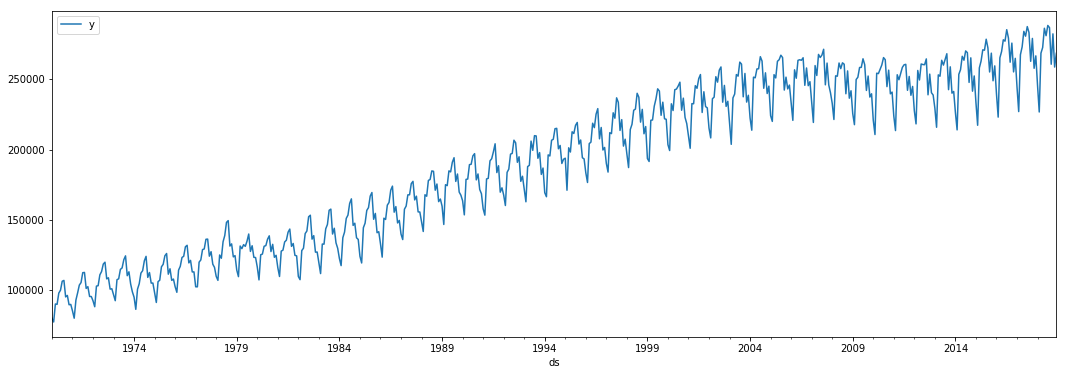

In [9]:
df.plot(x='ds',y='y',figsize=(18,6))

In [10]:
len(df)

588

In [11]:
len(df) - 12

576

In [12]:
train = df.iloc[:576]
test = df.iloc[576:]

In [13]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=12,freq='MS')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
583,2018-08-01,263219.378669,274037.281124,285268.897374,263173.174228,263246.223781,16451.125033,16451.125033,16451.125033,16451.125033,16451.125033,16451.125033,0.0,0.0,0.0,279670.503702
584,2018-09-01,263357.665883,255410.541830,267413.435617,263295.416146,263411.376689,-1666.545411,-1666.545411,-1666.545411,-1666.545411,-1666.545411,-1666.545411,0.0,0.0,0.0,261691.120472
585,2018-10-01,263491.492218,262966.228576,274380.957021,263408.762008,263585.130464,5310.587893,5310.587893,5310.587893,5310.587893,5310.587893,5310.587893,0.0,0.0,0.0,268802.080112
586,2018-11-01,263629.779432,249742.982799,261067.522669,263514.733653,263746.579495,-8203.436940,-8203.436940,-8203.436940,-8203.436940,-8203.436940,-8203.436940,0.0,0.0,0.0,255426.342492
587,2018-12-01,263763.605767,251149.150322,262607.926393,263612.379376,263911.171173,-6916.514689,-6916.514689,-6916.514689,-6916.514689,-6916.514689,-6916.514689,0.0,0.0,0.0,256847.091078


In [15]:
test.tail()

,ds,y
583,2018-08-01,286608.0
584,2018-09-01,260595.0
585,2018-10-01,282174.0
586,2018-11-01,258590.0
587,2018-12-01,268413.0


[Info on ax= parameter](https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure)

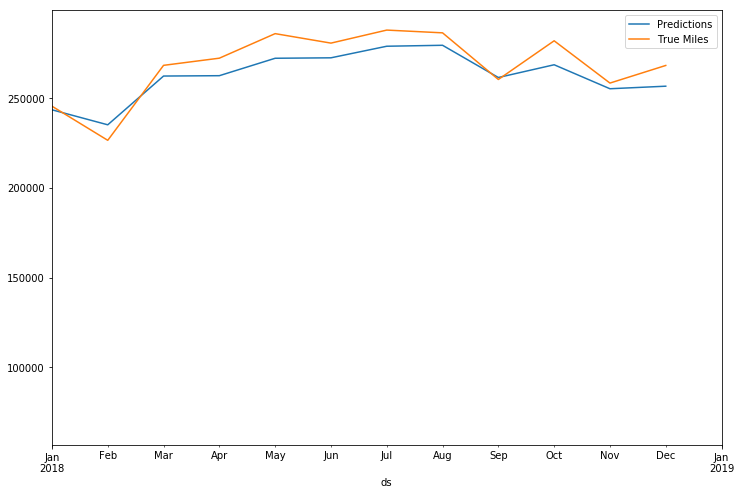

In [16]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax,xlim=('2018-01-01','2019-01-01'))

In [17]:
from statsmodels.tools.eval_measures import rmse

In [18]:
predictions = forecast.iloc[-12:]['yhat']

In [19]:
predictions

576    243683.663737
577    235311.776917
578    262511.200772
579    262708.863987
580    272429.495856
581    272679.913346
582    279136.474721
583    279670.503702
584    261691.120472
585    268802.080112
586    255426.342492
587    256847.091078
Name: yhat, dtype: float64

In [20]:
test['y']

576    245695.0
577    226660.0
578    268480.0
579    272475.0
580    286164.0
581    280877.0
582    288145.0
583    286608.0
584    260595.0
585    282174.0
586    258590.0
587    268413.0
Name: y, dtype: float64

In [21]:
rmse(predictions,test['y'])

8750.25052083061

In [22]:
test.mean()

y    268739.666667
dtype: float64

# Prophet Diagnostics

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

In [23]:
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [24]:
len(df)

588

In [25]:
len(df)/12

49.0

The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

In [26]:
help(pd.Timedelta)

Help on class Timedelta in module pandas._libs.tslibs.timedeltas:

class Timedelta(_Timedelta)
 |  Timedelta(value=<object object at 0x00000207E4AA6440>, unit=None, **kwargs)
 |  
 |  Represents a duration, the difference between two dates or times.
 |  
 |  Timedelta is the pandas equivalent of python's ``datetime.timedelta``
 |  and is interchangeable with it in most cases.
 |  
 |  Parameters
 |  ----------
 |  value : Timedelta, timedelta, np.timedelta64, string, or integer
 |  unit : str, optional
 |      Denote the unit of the input, if input is an integer. Default 'ns'.
 |      Possible values:
 |      {'Y', 'M', 'W', 'D', 'days', 'day', 'hours', hour', 'hr', 'h',
 |      'm', 'minute', 'min', 'minutes', 'T', 'S', 'seconds', 'sec', 'second',
 |      'ms', 'milliseconds', 'millisecond', 'milli', 'millis', 'L',
 |      'us', 'microseconds', 'microsecond', 'micro', 'micros', 'U',
 |      'ns', 'nanoseconds', 'nano', 'nanos', 'nanosecond', 'N'}
 |  days, seconds, microseconds,
 |  m

In [27]:
# Initial 5 years training period
initial = 5 * 365
initial = str(initial) + ' days'
# Fold every 5 years
period = 5 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

In [28]:
df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon)

INFO:fbprophet:Making 9 forecasts with cutoffs between 1976-12-11 00:00:00 and 2016-12-01 00:00:00


In [29]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1977-01-01,108479.087389,107097.448395,109837.737192,102445.0,1976-12-11
1,1977-02-01,102996.111525,101589.535637,104379.712652,102416.0,1976-12-11
2,1977-03-01,118973.318113,117420.058470,120336.900364,119960.0,1976-12-11
3,1977-04-01,120612.923709,119179.847793,122094.927131,121513.0,1976-12-11
4,1977-05-01,127883.031830,126559.988349,129424.743511,128884.0,1976-12-11


In [30]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
103,2017-08-01,273328.467970,267791.438144,278834.690992,283184.0,2016-12-01
104,2017-09-01,255447.843997,249372.298698,261035.899139,262673.0,2016-12-01
105,2017-10-01,262552.901413,256639.745481,267945.690028,278937.0,2016-12-01
106,2017-11-01,249204.331440,243869.040521,255391.943884,257712.0,2016-12-01
107,2017-12-01,250450.721819,244680.309743,255791.522658,266535.0,2016-12-01


In [31]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,52 days,2.437359e+07,4936.961190,4528.637861,0.027750,0.4
1,53 days,2.187095e+07,4676.638408,4262.628303,0.024999,0.4
2,54 days,1.842045e+07,4291.904691,3732.310696,0.020061,0.5
3,55 days,2.351247e+07,4848.965429,4271.125183,0.023241,0.4
4,57 days,2.115130e+07,4599.053997,3989.900860,0.021416,0.5
5,58 days,2.340954e+07,4838.340856,4267.060996,0.022624,0.4
6,59 days,3.816209e+07,6177.547482,5084.706682,0.026311,0.4
7,60 days,3.893160e+07,6239.518878,5149.948941,0.026779,0.4
8,62 days,3.732553e+07,6109.462715,4934.565372,0.025835,0.4
9,80 days,3.233278e+07,5686.192422,4319.783877,0.023741,0.5


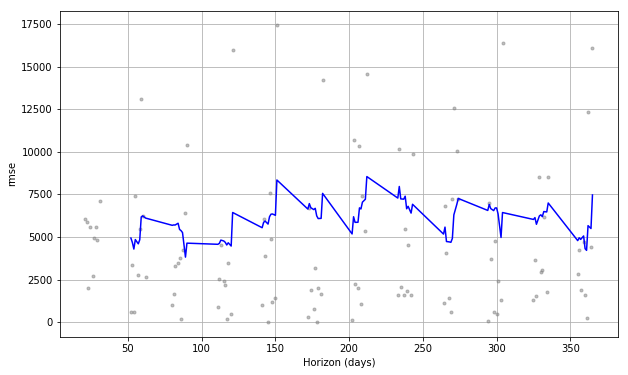

In [32]:
plot_cross_validation_metric(df_cv, metric='rmse');

MAPE is Mean Absolute Percentage Error

https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

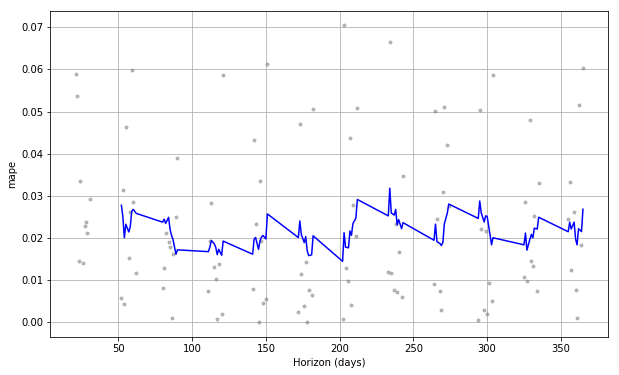

In [33]:
plot_cross_validation_metric(df_cv, metric='mape');